Loaded product catalog:
  product_id       product_name     category  \
0       P001      Basic T-Shirt      Apparel   
1       P002       Casual Pants      Apparel   
2       P003      Running Shoes     Footwear   
3       P004  Everyday Sneakers     Footwear   
4       P005      Mobile Device  Electronics   

                                         description  
0  Comfortable cotton t-shirt suitable for daily ...  
1             Everyday pants for casual or work use.  
2  Lightweight shoes suitable for running or walk...  
3  Casual sneakers for daily activities and light...  
4  Generic smartphone or mobile device for commun...  


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Created normalized embeddings for all products.
FAISS index built with 25 products.

Sample query results:

Query: laptop
  1. Laptop (Category: Electronics, Similarity: 0.714)
  2. Wireless Mouse (Category: Electronics, Similarity: 0.351)
  3. Mobile Device (Category: Electronics, Similarity: 0.32)

Query: headphones
  1. Headphones (Category: Electronics, Similarity: 0.74)
  2. Smartwatch (Category: Electronics, Similarity: 0.302)
  3. Wireless Mouse (Category: Electronics, Similarity: 0.299)

Query: sports equipment
  1. Sports Equipment (Category: Sports, Similarity: 0.846)
  2. Basic Backpack (Category: Accessories, Similarity: 0.454)
  3. Wireless Mouse (Category: Electronics, Similarity: 0.409)

Query: smartwatch
  1. Smartwatch (Category: Electronics, Similarity: 0.774)
  2. Wireless Mouse (Category: Electronics, Similarity: 0.404)
  3. Mobile Device (Category: Electronics, Similarity: 0.377)

Query: backpack
  1. Basic Backpack (Category: Accessories, Similarity: 0.7)
  2. Cas

/tmp/ipython-input-3474849215.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="category", palette="pastel")


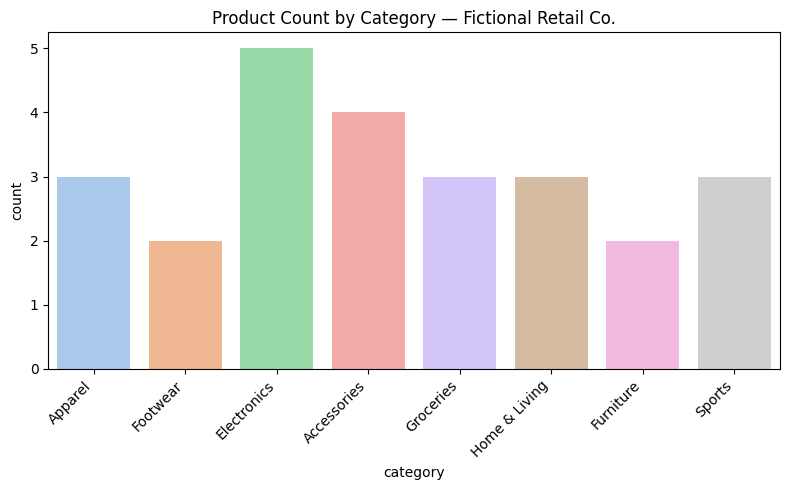

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [5]:
# ===============================================================
# PROJECT OVERVIEW — Fictional Retail Co. Product Recommendation
# ===============================================================
# This project builds a simple Product Recommendation System
# using only free and open-source tools.
#
# Core idea:
# 1. Convert all product details (name, category, description) into embeddings (numbers) using a free model.
# 2. Store embeddings in FAISS, a fast search engine for similar items.
# 3. When a user types a query:
#    - Find the most semantically similar products.
#    - If query is outside the store’s inventory, return a friendly message.
#
# Example:
# - User queries: "laptop", "headphones", "sports equipment".
# - The system recommends matching products, or tells the user if no match exists.
#
# ===============================================================
# STEP-BY-STEP EXPLANATION
# ===============================================================
# Step 1 — Install Dependencies
# We install the Python libraries needed:
# - sentence-transformers → to convert text into embeddings.
# - faiss-cpu → to search for similar products quickly.
# - pandas → to handle product data.
# - matplotlib & seaborn → optional for visualization.
# - gradio → optional interactive UI.
#
# Step 2 — Load Product Data
# Load a CSV file containing product catalog from /content/fictional_retail_docs.
# Columns include: product_name, category, description.
#
# Step 3 — Embed Products
# Use all-MiniLM-L6-v2 to convert product information into numeric vectors.
# Combining name + category + description ensures short queries like "Laptop" match better.
#
# Step 4 — Build FAISS Index
# Store all embeddings in a FAISS index for fast nearest-neighbor search.
# Use cosine similarity for more reliable results.
#
# Step 5 — Query Function with Out-of-Inventory Handling
# - Convert user query into embedding.
# - Search FAISS for top-k closest products.
# - If similarity of best match is below threshold → return friendly message.
# - Else → return recommended products with similarity scores.
#
# Step 6 — Test & Display
# - Run multiple sample queries (some inside catalog, some outside).
# - Show friendly messages for unknown queries.
#
# Step 7 — Optional Interactive Demo
# - Gradio interface lets users type queries and get recommendations instantly.
#
# ===============================================================
# SYSTEM FLOW
# ===============================================================
# 1. Load product CSV
# 2. Convert product details to embeddings (name + category + description)
# 3. Normalize embeddings and build FAISS search index (cosine similarity)
# 4. User query -> embedding -> FAISS search -> check similarity threshold
# 5. Return top-k products or friendly message
# 6. Optional: Gradio interactive UI
#
# ===============================================================
# TOOLS USED (All Free)
# ===============================================================
# - SentenceTransformer: all-MiniLM-L6-v2 (embeddings)
# - FAISS: fast nearest neighbor search
# - Pandas: data management
# - Gradio: interactive interface
# - Matplotlib / Seaborn: optional visualization
#
# Fully open-source. No paid API keys required.
# ===============================================================

# ===============================================================
# 1. Install Dependencies
# ===============================================================
!pip install --quiet sentence-transformers faiss-cpu pandas matplotlib seaborn gradio

# ===============================================================
# 2. Imports & Load Data
# ===============================================================
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

# Path to product CSV
folder_path = "/content/fictional_retail_docs"
csv_path = os.path.join(folder_path, "fictional_retail_products.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path}. Please upload your CSV file first.")

# Load CSV
df = pd.read_csv(csv_path)
print("Loaded product catalog:")
print(df.head())

# ===============================================================
# 3. Create Embeddings (Name + Category + Description)
# ===============================================================
embed_model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=False)

# Combine product_name, category, description for better matches
product_texts = (df["product_name"] + " " + df["category"] + " " + df["description"]).tolist()

# Generate embeddings
product_embeddings = embed_model.encode(product_texts, convert_to_numpy=True, show_progress_bar=True)

# Normalize embeddings for cosine similarity
product_embeddings = product_embeddings / np.linalg.norm(product_embeddings, axis=1, keepdims=True)

print("Created normalized embeddings for all products.")

# ===============================================================
# 4. Build FAISS Index (Cosine Similarity)
# ===============================================================
embedding_dim = product_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  # Inner Product = Cosine similarity for normalized vectors
index.add(product_embeddings)
print(f"FAISS index built with {index.ntotal} products.")

# ===============================================================
# 5. Query Function with Out-of-Inventory Handling
# ===============================================================
SIMILARITY_THRESHOLD = 0.5  # Lowered threshold to match broader queries

def recommend_products_safe(query, k=3):
    """
    Returns top-k product recommendations or a friendly message if no match.
    """
    # Embed query and normalize
    query_emb = embed_model.encode([query], convert_to_numpy=True)
    query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)

    # Search FAISS
    distances, indices = index.search(query_emb, k)
    sims = distances[0].tolist()  # Cosine similarity values

    # If best match is below threshold → friendly message
    if sims[0] < SIMILARITY_THRESHOLD:
        return {
            "message": f"Sorry, we currently do not have products related to '{query}'. "
                       "Please check other categories."
        }

    # Return top-k products
    recommended = []
    for idx, sim in zip(indices[0], sims):
        recommended.append({
            "product_name": df.iloc[idx]["product_name"],
            "category": df.iloc[idx]["category"],
            "similarity": round(sim, 3)
        })

    return {"recommended_products": recommended}

# ===============================================================
# 6. Test Queries
# ===============================================================
sample_queries = [
    "laptop",
    "headphones",
    "sports equipment",
    "smartwatch",
    "backpack",
    "t-shirt"
]

print("\nSample query results:")
for q in sample_queries:
    res = recommend_products_safe(q, k=3)
    print(f"\nQuery: {q}")
    if "message" in res:
        print("Response:", res["message"])
    else:
        for i, prod in enumerate(res["recommended_products"], 1):
            print(f"  {i}. {prod['product_name']} (Category: {prod['category']}, Similarity: {prod['similarity']})")

# ===============================================================
# 7. Optional Visualization (Product Count by Category)
# ===============================================================
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="category", palette="pastel")
plt.title("Product Count by Category — Fictional Retail Co.")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ===============================================================
# 8. Optional Gradio Interface
# ===============================================================
def recommend_ui(query):
    res = recommend_products_safe(query, k=3)
    if "message" in res:
        return res["message"]
    return "\n".join([f"{p['product_name']} (Category: {p['category']})" for p in res["recommended_products"]])

demo = gr.Interface(
    fn=recommend_ui,
    inputs=gr.Textbox(lines=3, placeholder="Type your product query here..."),
    outputs="text",
    title="Fictional Retail Co. – Product Recommendation",
    description="Enter any product query to get recommendations from the available catalog."
)

demo.launch(share=False)
